In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import xarray as xr
import numpy as np
ds_dmsp = xr.open_dataset('/content/drive/MyDrive/ndui/dmsp_2012_austin.nc').constant
ds_viirs = xr.open_dataset('/content/drive/MyDrive/ndui/viirs_2012_austin.nc').avg_rad

In [3]:
x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)

In [4]:
import numpy as np

def unpatchify(patches, img_shape):
    patch_size = patches.shape[1]
    assert patches.shape[0] == (img_shape[0] // patch_size) * (img_shape[1] // patch_size), "Patches and image shape are not compatible"

    img = np.zeros(img_shape, dtype=patches.dtype)
    patch_idx = 0

    for i in range(0, img_shape[0], patch_size):
        for j in range(0, img_shape[1], patch_size):
            img[i:i + patch_size, j:j + patch_size] = patches[patch_idx]
            patch_idx += 1

    return img

def patchify(img, patch_size):
    img_shape = img.shape
    patches = np.array([img[i:i + patch_size, j:j + patch_size] for i in range(0, img_shape[0], patch_size) for j in range(0, img_shape[1], patch_size)])
    return patches

In [5]:
# Create patches from the image
patch_size = 32
img = x_train[:576,:576]
patches = patchify(img, patch_size)

In [6]:
x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:576,:576], patch_size)
y_train_patches = patchify(y_train[:576,:576], patch_size)
x_train_patches.shape

(324, 32, 32)

In [7]:
x_val_patches = x_train_patches[200:300]
y_val_patches = y_train_patches[200:300]

x_test_patches = x_train_patches[300:]
y_test_patches = y_train_patches[300:]

x_train_patches = x_train_patches[:200]
y_train_patches = y_train_patches[:200]

In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim

In [9]:
class ncDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = torch.from_numpy(self.data[index]).unsqueeze(0)
        y = torch.from_numpy(self.targets[index]).unsqueeze(0)
        # x = self.data[index]
        # y = self.targets[index]
        # x = x.to(dtype=torch.float32)
        # y = y.to(dtype=torch.float32)
        return x, y

    def __len__(self):
        return len(self.data)

In [10]:
train_dataset = ncDataset(x_train_patches, y_train_patches)
val_dataset = ncDataset(x_val_patches, y_val_patches)
test_dataset = ncDataset(x_val_patches, y_val_patches)

In [11]:
lr, hr = train_dataset.__getitem__(0)
print(lr.shape, hr.shape, train_dataset.__len__())

torch.Size([1, 32, 32]) torch.Size([1, 32, 32]) 200


In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [13]:
for batch in train_dataloader:
    data, targets = batch
    print(data.size())  # Should print torch.Size([16, 1, 30, 30])
    print(targets.size())  # Should print torch.Size([16, 1, 30, 601])
    break

torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])


In [14]:
import torch
from diffusers import UNet2DModel, EDMEulerScheduler, LCMScheduler
from torch.optim import Adam
from tqdm import tqdm
# from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np

In [15]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [16]:
class_emb_size = 1
device = 'cuda'
model = UNet2DModel(
    sample_size=32,  # Target image resolution
    in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
    out_channels=1,  # Number of output channels
    layers_per_block=2,  # Number of ResNet layers per UNet block

    # Ensure block_out_channels matches the number of down_block_types
    block_out_channels=(64, 128, 256, 512),

    down_block_types=(
        "DownBlock2D",  # Regular ResNet downsampling block
        "AttnDownBlock2D",  # Spatial self-attention downsampling block
        "AttnDownBlock2D",
        "DownBlock2D",  # Additional down block
    ),

    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # More attention layers
        "UpBlock2D",
    ),
).to(device)

In [17]:
!pip install wandb

# LCM

In [18]:
noise_scheduler = LCMScheduler(num_train_timesteps=1000)

In [19]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="lcm", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manmeet3591 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [20]:
# How many runs through the data should we do?
n_epochs =5000


# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise

        loss.backward()
        opt.step()
        opt.zero_grad()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Streaming output truncated to the last 5000 lines.
Epoch 2500: Avg Train Loss: 0.000507, Avg Val Loss: 0.018355
Early stopping patience: 604/5000
Epoch 2501: Avg Train Loss: 0.000319, Avg Val Loss: 0.017982
Early stopping patience: 605/5000
Epoch 2502: Avg Train Loss: 0.000247, Avg Val Loss: 0.024511
Early stopping patience: 606/5000
Epoch 2503: Avg Train Loss: 0.000258, Avg Val Loss: 0.013181
Early stopping patience: 607/5000
Epoch 2504: Avg Train Loss: 0.000255, Avg Val Loss: 0.021019
Early stopping patience: 608/5000
Epoch 2505: Avg Train Loss: 0.000227, Avg Val Loss: 0.011987
Early stopping patience: 609/5000
Epoch 2506: Avg Train Loss: 0.000208, Avg Val Loss: 0.023212
Early stopping patience: 610/5000
Epoch 2507: Avg Train Loss: 0.000323, Avg Val Loss: 0.006957
Early stopping patience: 611/5000
Epoch 2508: Avg Train Loss: 0.000249, Avg Val Loss: 0.010009
Early stopping patience: 612/5000
Epoch 2509: Avg Train Loss: 0.000217, Avg Val Loss: 0.028815
Early stopping patience: 613/5000

In [22]:
model.eval()
num_inference_steps = 50
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps:   0%|          | 0/50 [00:00<?, ?it/s]

In [23]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [26]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [28]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_ddpm': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

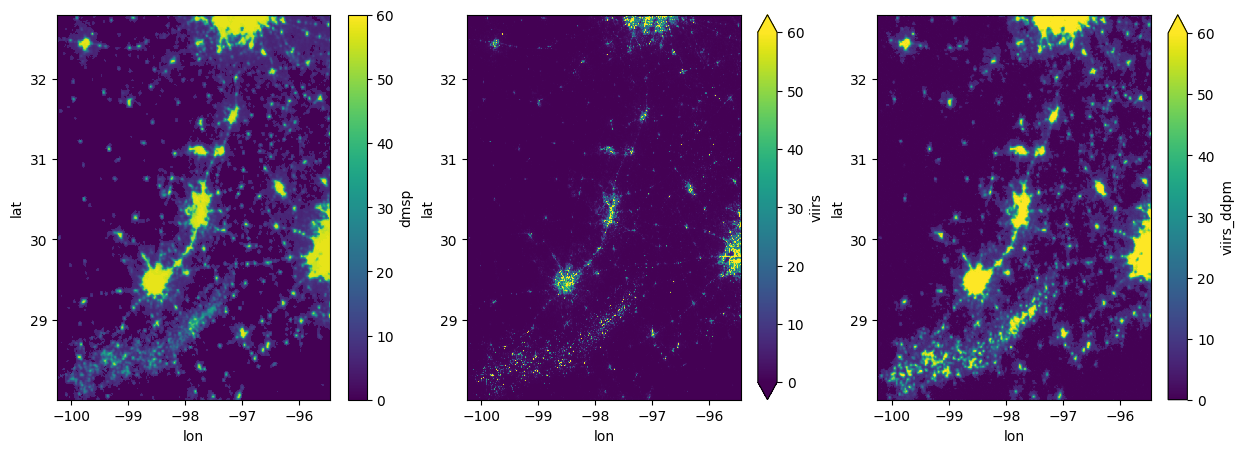

In [29]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_ddpm.plot(ax=ax[2], vmax=60)

# Inference time = 5

In [30]:
model.eval()
num_inference_steps = 5
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps:   0%|          | 0/5 [00:00<?, ?it/s]

In [31]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [32]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [33]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_ddpm': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

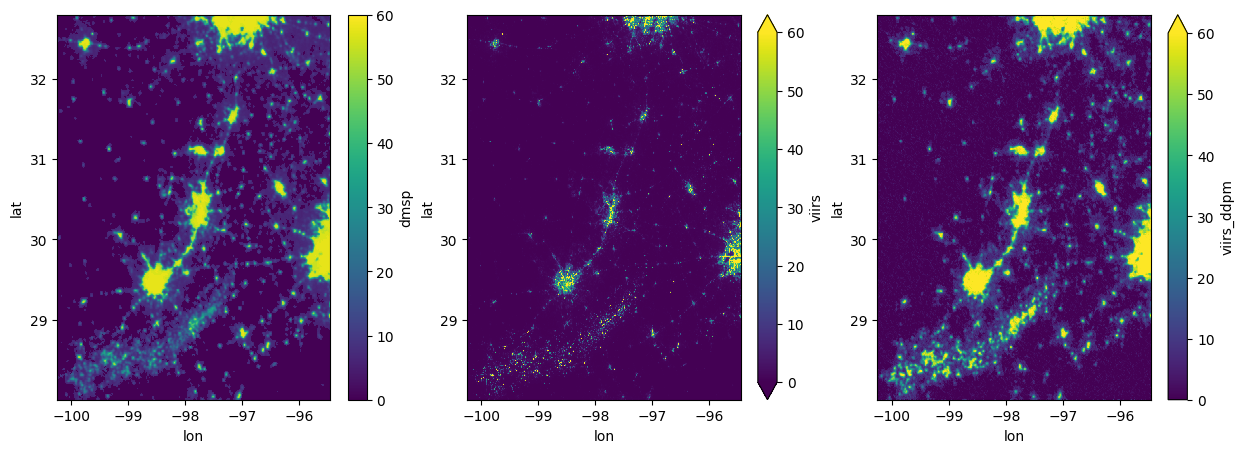

In [34]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_ddpm.plot(ax=ax[2], vmax=60)

# Inference time = 1

In [35]:
model.eval()
num_inference_steps = 1
noise_scheduler.set_timesteps(num_inference_steps)

x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [37]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [38]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_ddpm': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

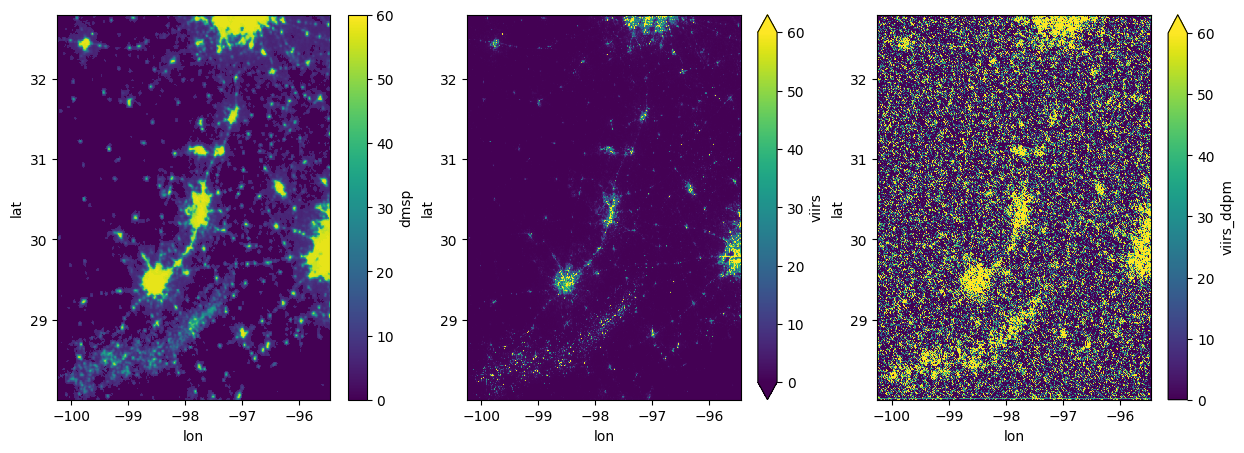

In [39]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_ddpm.plot(ax=ax[2], vmax=60)